In [10]:
import argparse
import os
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import kerastuner as kt
from kerastuner.tuners import Hyperband
import statsmodels.api as sm

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.alphabet import ALPHABET_DNA, ALPHABET_PROTEIN
from rna_learn.transform import (
    sequence_embedding, 
    normalize, denormalize,
    one_hot_encode_classes,
    split_train_test_set,
    combine_sequences,
)
from rna_learn.hyperband import hyperband_densenet_model, load_extra_logits

In [11]:
sns.set(palette='colorblind', font_scale=1.3)
logging.basicConfig(level=logging.INFO, format="%(asctime)s (%(levelname)s) %(message)s")

In [4]:
hyperband_run_id = 'run_hjaha'
extra_prot_run_id = 'run_r0cvl_top10'

In [5]:
train_set_path = os.path.join(os.getcwd(), 'data/gtdb/dataset_full_train.csv')
test_set_path = os.path.join(os.getcwd(), 'data/gtdb/dataset_full_test.csv')

train_df = pd.read_csv(train_set_path)
dataset_df = pd.read_csv(test_set_path)

In [6]:
alphabet = ALPHABET_DNA
y_train = train_df['temperature'].values.astype('float64')
mean, std = np.mean(y_train), np.std(y_train)

raw_sequences = dataset_df['nucleotide_sequence'].values

x_dna = sequence_embedding(raw_sequences, alphabet, dtype='float32')

y = dataset_df['temperature'].values.astype('float32')
y_norm = normalize(y, mean, std)

In [12]:
extra_model_path = os.path.join(
    os.getcwd(), 
    f'hyperband_logs/protein/{extra_prot_run_id}/best_model.h5',
)
extra_logits_model = tf.keras.models.load_model(extra_model_path)

extra_seq = np.array([
    s[:-1]
    for s in dataset_df['amino_acid_sequence'].values
])
x_seq_extras = sequence_embedding(extra_seq, ALPHABET_PROTEIN, dtype='float32')

x_extras = load_extra_logits(extra_logits_model, x_seq_extras)

2020-03-06 15:46:49,642 (WARNING) No training configuration found in save file: the model was *not* compiled. Compile it manually.
2020-03-06 15:46:55,297 (INFO) Part 1 / 20
2020-03-06 15:47:05,274 (INFO) Part 2 / 20
2020-03-06 15:47:11,432 (INFO) Part 3 / 20
2020-03-06 15:47:17,534 (INFO) Part 4 / 20
2020-03-06 15:47:23,245 (INFO) Part 5 / 20
2020-03-06 15:47:29,115 (INFO) Part 6 / 20
2020-03-06 15:47:34,946 (INFO) Part 7 / 20
2020-03-06 15:47:40,852 (INFO) Part 8 / 20
2020-03-06 15:47:46,838 (INFO) Part 9 / 20
2020-03-06 15:47:53,024 (INFO) Part 10 / 20
2020-03-06 15:47:59,359 (INFO) Part 11 / 20
2020-03-06 15:48:06,035 (INFO) Part 12 / 20
2020-03-06 15:48:12,750 (INFO) Part 13 / 20
2020-03-06 15:48:19,330 (INFO) Part 14 / 20
2020-03-06 15:48:25,854 (INFO) Part 15 / 20
2020-03-06 15:48:32,184 (INFO) Part 16 / 20
2020-03-06 15:48:38,869 (INFO) Part 17 / 20
2020-03-06 15:48:45,692 (INFO) Part 18 / 20
2020-03-06 15:48:52,333 (INFO) Part 19 / 20
2020-03-06 15:48:59,154 (INFO) Part 20 / 2

## Hyperband Model

In [13]:
build_model_fn = hyperband_densenet_model(
    n_inputs=len(ALPHABET_DNA), 
    n_extras=x_extras.shape[1],
    init_n_layers=12,
    init_growth_rate=12,
    init_l2_reg=1e-5,
    init_learning_rate=1e-03,
)

In [14]:
hypermodel = Hyperband(
    build_model_fn,
    max_epochs=50,
    objective=kt.Objective('val_loss', 'min'),
    factor=3,
    hyperband_iterations=1,
    project_name=f'hyperband_logs/dna/{hyperband_run_id}',
)

INFO:tensorflow:Reloading Oracle from existing project ./hyperband_logs/dna/run_hjaha/oracle.json


2020-03-06 15:49:05,755 (INFO) Reloading Oracle from existing project ./hyperband_logs/dna/run_hjaha/oracle.json


INFO:tensorflow:Reloading Tuner from ./hyperband_logs/dna/run_hjaha/tuner0.json


2020-03-06 15:49:06,717 (INFO) Reloading Tuner from ./hyperband_logs/dna/run_hjaha/tuner0.json


In [15]:
best_hyperparameters_sets = hypermodel.get_best_hyperparameters(10)

In [16]:
best_model_idx = 0
best_hyperparameters = best_hyperparameters_sets[best_model_idx]

In [17]:
best_hyperparameters.values

{'kernel_size_l1': 5,
 'kernel_size_l2': 5,
 'kernel_size_l3': 3,
 'kernel_size_l4': 10,
 'kernel_size_l5': 7,
 'kernel_size_l6': 7,
 'kernel_size_l7': 5,
 'kernel_size_l8': 7,
 'kernel_size_l9': 8,
 'kernel_size_l10': 6,
 'kernel_size_l11': 6,
 'kernel_size_l12': 2,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [18]:
trials = hypermodel.oracle.get_best_trials(10)
best_model = hypermodel.load_model(trials[best_model_idx])
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, None, 12)     252         sequence[0][0]                   
__________________________________________________________________________________________________
concat_1 (Concatenate)          (None, None, 16)     0           sequence[0][0]                   
                                                                 conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, None, 12)     972         concat_1[0][0]               

Non-trainable params: 0
__________________________________________________________________________________________________


## Evaluation

In [19]:
%%time
n_steps = 30
b = int(np.ceil(len(x_dna) / n_steps))
y_mean = []
for idx in range(n_steps):
    print(f'{idx + 1} / {n_steps}')
    bounds = (idx * b, (idx + 1) * b)
    x_ = x_dna[bounds[0]:bounds[1]]
    x_extras_ = x_extras[bounds[0]:bounds[1]]
    
    y_hat_ = best_model((x_, x_extras_))
    y_mean_ = denormalize(y_hat_.mean().numpy(), mean, std).flatten().tolist()
    y_mean += y_mean_

y_mean = np.array(y_mean)

1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30
CPU times: user 8min 40s, sys: 3min 37s, total: 12min 18s
Wall time: 2min 20s


In [20]:
mae = np.mean(np.abs(y_mean.flatten() - y))
rmse = np.sqrt(np.mean((y_mean.flatten() - y) **2))
correlation = np.corrcoef(y, y_mean.flatten())[0, 1]

print(f'Mean Absolute Error    = {mae:.2f}')
print(f'Root Mean Square Error = {rmse:.2f}')
print(f'Correlation            = {correlation:.2f}')

Mean Absolute Error    = 9.99
Root Mean Square Error = 12.84
Correlation            = 0.72


In [21]:
def predictions_per_specie(dataset_df, y_true, y_pred):
    y_species_pred = []
    y_species_actual = []
    y_species_pred_std  = []
    
    sequence_ids = sorted(dataset_df['gtdb_genome_representative'].unique().tolist())
    for sequence_id in sequence_ids:
        indices = dataset_df[dataset_df['gtdb_genome_representative'] == sequence_id].index
        
        truth = y_true[indices[0]]
        prediction = np.mean(y_pred[indices])
        prediction_std = np.std(y_pred[indices])
        
        y_species_actual.append(truth)
        y_species_pred.append(prediction)
        y_species_pred_std.append(prediction_std)
    
    return np.array(y_species_actual), np.array(y_species_pred), np.array(y_species_pred_std)

In [22]:
def plot_true_vs_prediction_per_specie(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    x_straight = range(0, 80)
    ax.plot(x_straight, x_straight, '--', color=palette[1], linewidth=2)
    
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_p = y_pred[i]
        ax.plot(y_t, y_p, 'o', color=palette[0])
    
    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    ax.set_xlabel('Temperature °C (truth)')
    ax.set_ylabel('Temperature °C (prediction)')
    return f, ax

In [23]:
y_species_actual, y_species_pred, y_species_pred_std = predictions_per_specie(dataset_df, y, y_mean)

In [24]:
mae_species = np.mean(np.abs(y_species_pred.flatten() - y_species_actual))
rmse_species = np.sqrt(np.mean((y_species_pred.flatten() - y_species_actual) **2))
corr_species = np.corrcoef(y_species_actual, y_species_pred.flatten())[0, 1]

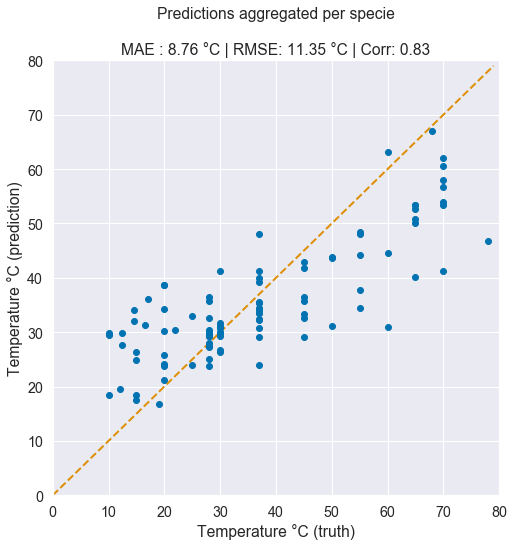

In [25]:
f, ax = plot_true_vs_prediction_per_specie(y_species_actual, y_species_pred);
title = f'Predictions aggregated per specie\n\n'
title += f'MAE : {mae_species:.2f} °C | '
title += f'RMSE: {rmse_species:.2f} °C | '
title += f'Corr: {corr_species:.2f}'
ax.set_title(title);

## Results per gene

In [26]:
def mae_per_gene(dataset_df, y_true, y_pred, plot_top=20):
    f, ax = plt.subplots(1, 1, figsize=(6, 12))
    palette = sns.color_palette()
    
    genes = np.array(sorted(dataset_df['gene_name'].unique().tolist()))
    
    results = []
    for i, gene in enumerate(genes):
        df = dataset_df[dataset_df['gene_name'] == gene]
        indices = df.index

        y_p = y_pred[indices]
        y_t = y_true[indices]
        
        results.append(np.mean(np.abs(y_p - y_t)))
    
    sorted_idx = np.argsort([np.sum(r) for r in results]).tolist()
    sorted_maes = np.array(results)[sorted_idx]
    
    cm = pd.DataFrame(
        sorted_maes[:plot_top], 
        index=[f'{g}' for i, g in enumerate(genes[sorted_idx][:plot_top])],
        columns=[''],
    )
    sns.heatmap(cm, cmap="Greys_r", annot=True, fmt='.2f', cbar=False, ax=ax);
    plt.yticks(rotation=0)
    ax.set_title('Mean average error (°C)')
    
    return f, ax, genes[sorted_idx], sorted_maes

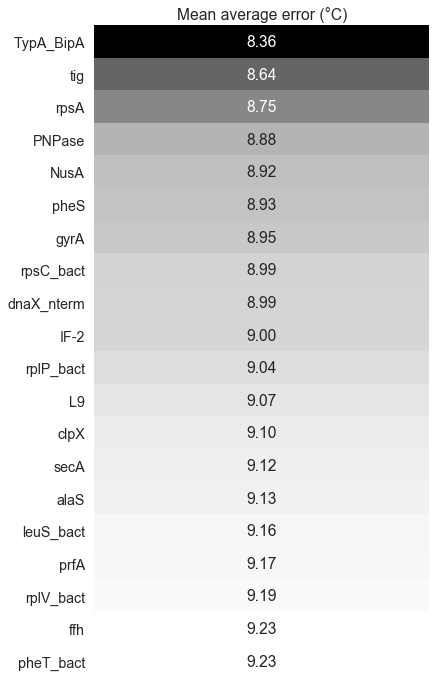

In [27]:
_, _, sorted_genes, sorted_gene_maes = mae_per_gene(dataset_df, y, y_mean.flatten(), plot_top=20)